# Librairies

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

2024-11-18 10:27:47.896031: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 10:27:48.884540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 10:27:48.947620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 10:27:48.964342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 10:27:49.071921: I tensorflow/core/platform/cpu_feature_guar

# Chargement de données

In [3]:
train_base_dir = '../Data/Data/'
clear_dir = os.path.join(train_base_dir, 'clear')
classes = ['clear', 'distorsion1', 'distorsion2', 'distorsion3','mvt1','mvt2','mvt3','gauss1','gauss2','gauss3','pixel1','pixel2','pixel3','pixelperm1','pixelperm2','pixdelperm3','fgsm1','fgsm2','fgsm3'] 

def verifier_et_lister_contenu(repertoire):
    if os.path.exists(repertoire):
        print(f"Le dossier '{repertoire}' contient les fichiers suivants :")
        for filename in os.listdir(repertoire):
            print(filename)
    else:
        print(f"Le dossier '{repertoire}' n'existe pas. Vérifiez le chemin.")

verifier_et_lister_contenu(clear_dir)


image_size = (128, 128)
batch_size = 64  


def charger_et_preparer_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, image_size)  
    img = img / 255.0  
    return img


def charger_images_et_labels(repertoire, label):
    images_paths = [os.path.join(repertoire, filename) for filename in os.listdir(repertoire)]
    labels = [label] * len(images_paths)
    return images_paths, labels

clear_images, clear_labels = charger_images_et_labels(clear_dir, 0)

def create_tf_dataset(image_paths, labels, batch_size, shuffle_data=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (charger_et_preparer_image(img_path), label), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle_data:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


Le dossier '../Data/Data/clear' contient les fichiers suivants :
clear_34.jpg
clear_172.jpg
clear_1576.jpg
clear_1107.jpg
clear_2747.jpg
clear_3468.jpg
clear_3386.jpg
clear_38.jpg
clear_4179.jpg
clear_4279.jpg
clear_848.jpg
clear_1857.jpg
clear_3676.jpg
clear_1239.jpg
clear_2803.jpg
clear_992.jpg
clear_2422.jpg
clear_1462.jpg
clear_2972.jpg
clear_1630.jpg
clear_1297.jpg
clear_2647.jpg
clear_3237.jpg
clear_2322.jpg
clear_495.jpg
clear_259.jpg
clear_3166.jpg
clear_2242.jpg
clear_2088.jpg
clear_132.jpg
clear_3547.jpg
clear_62.jpg
clear_1096.jpg
clear_116.jpg
clear_1321.jpg
clear_2632.jpg
clear_2597.jpg
clear_3158.jpg
clear_3298.jpg
clear_2015.jpg
clear_3218.jpg
clear_2283.jpg
clear_2195.jpg
clear_3331.jpg
clear_286.jpg
clear_143.jpg
clear_3418.jpg
clear_1608.jpg
clear_3945.jpg
clear_3980.jpg
clear_3633.jpg
clear_1413.jpg
clear_3718.jpg
clear_847.jpg
clear_905.jpg
clear_3473.jpg
clear_2908.jpg
clear_2207.jpg
clear_190.jpg
clear_1751.jpg
clear_3085.jpg
clear_741.jpg
clear_511.jpg
clear_3839

# Création du modèle

In [4]:


def create_model():
    model = keras.models.Sequential([
        keras.layers.Input((128, 128, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')  # 2 classes
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
def process_model(model,obscur_dir) :

    obscur_images, obscur_labels = charger_images_et_labels(obscur_dir, 1)
    all_images = clear_images + obscur_images
    all_labels = clear_labels + obscur_labels
    X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, stratify=all_labels)



    train_dataset = create_tf_dataset(X_train, y_train,batch_size,True)
    validation_dataset = create_tf_dataset(X_val, y_val,batch_size,False)
    train_labels = np.concatenate([labels for _, labels in train_dataset], axis=0)
    val_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)
    print(f"Distribution des labels dans le jeu d'entraînement: {np.bincount(train_labels)}")
    print(f"Distribution des labels dans le jeu de validation: {np.bincount(val_labels)}")


    history = model.fit(
        train_dataset, 
        validation_data=validation_dataset,  
        epochs=3,   
        verbose=1    
    ) 

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Model accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = model.predict(validation_dataset)
    predictions = np.argmax(predictions, axis=1)
    true_labels = val_labels
    print(classification_report(true_labels, predictions))
    print(f"True labels: {true_labels[:10]}")
    print(f"Predictions: {predictions[:10]}")
    print(f"Shape of true_labels: {true_labels.shape}")
    print(f"Shape of predictions: {predictions.shape}")

    cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
    class_names = [str(0),str(1)]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig("matrice.png")
    plt.show()

    

# Distorsion

Distribution des labels dans le jeu d'entraînement: [3451 3412]
Distribution des labels dans le jeu de validation: [863 853]
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.5121 - loss: 0.9060 - val_accuracy: 0.5035 - val_loss: 0.6928
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.5219 - loss: 0.6921 - val_accuracy: 0.5082 - val_loss: 0.6936
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 213ms/step - accuracy: 0.5577 - loss: 0.6817 - val_accuracy: 0.5979 - val_loss: 0.6588
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.6201 - loss: 0.6351 - val_accuracy: 0.6538 - val_loss: 0.6055
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - accuracy: 0.7269 - loss: 0.5354 - val_accuracy: 0.6795 - val_loss: 0.5683
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.7698 - loss: 0.4648 - val_accuracy: 0.6999 - val_loss: 0.5518
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - accuracy: 0.8364 - loss: 0.3549 

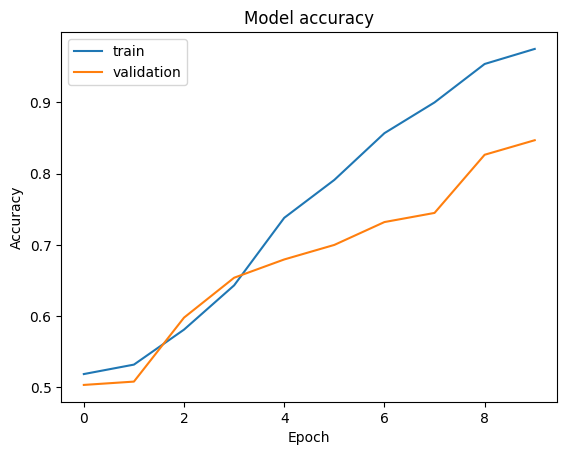

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       863
           1       0.89      0.78      0.84       853

    accuracy                           0.85      1716
   macro avg       0.85      0.85      0.85      1716
weighted avg       0.85      0.85      0.85      1716

True labels: [0 0 1 0 0 1 0 0 0 0]
Predictions: [0 0 1 0 1 0 1 0 0 0]
Shape of true_labels: (1716,)
Shape of predictions: (1716,)


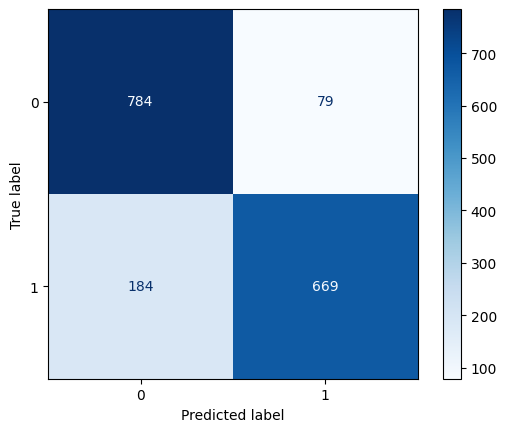

In [8]:
# DIstorsion1

model=create_model()
distorsion1_dir = os.path.join(train_base_dir, 'distorsion1')
process_model(model,distorsion1_dir)

# Sauvegarde du modèle
# model.save('model_dist1.keras') #modele lourd pour push sur git





Distribution des labels dans le jeu d'entraînement: [3451 3452]
Distribution des labels dans le jeu de validation: [863 863]
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - accuracy: 0.7337 - loss: 0.8030 - val_accuracy: 0.9994 - val_loss: 0.0048
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9994 - val_loss: 0.0016
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 1.0000 - loss: 4.2315e-04 - val_accuracy: 0.9994 - val_loss: 9.8370e-04
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - accuracy: 1.0000 - loss: 1.3997e-04 - val_accuracy: 0.9994 - val_loss: 0.0017
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 1.0000 - loss: 8.2479e-05 - val_accuracy: 0.9994 - val_loss: 5.4474e-04
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 1.0000 - loss: 6.0828e-05 - val_accuracy: 0.9994 - val_loss: 5.9384e-04
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - accu

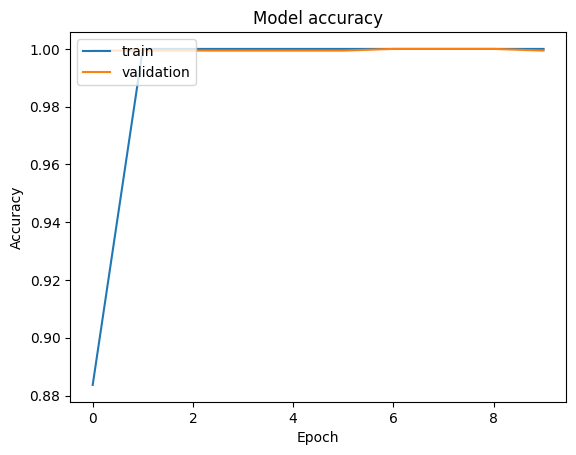

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       863

    accuracy                           1.00      1726
   macro avg       1.00      1.00      1.00      1726
weighted avg       1.00      1.00      1.00      1726

True labels: [0 1 1 1 1 1 0 0 0 1]
Predictions: [0 1 1 1 1 1 0 0 0 1]
Shape of true_labels: (1726,)
Shape of predictions: (1726,)


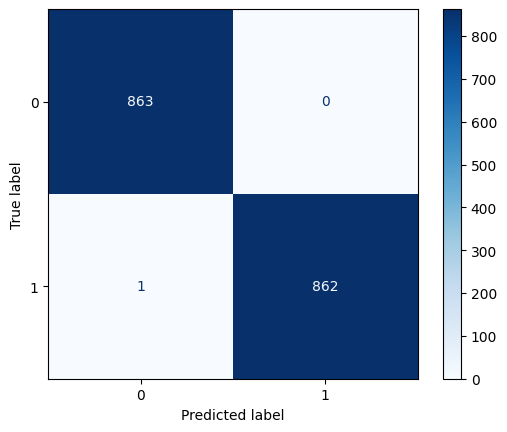

In [9]:
# DIstorsion2

model=create_model()
distorsion2_dir = os.path.join(train_base_dir, 'distorsion2')
process_model(model,distorsion2_dir)
# Sauvegarde du modèle
# model.save('model_dist2.keras') #modele lourd pour push sur git





Distribution des labels dans le jeu d'entraînement: [3451 3467]
Distribution des labels dans le jeu de validation: [863 867]
Epoch 1/3
109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.8409 - loss: 0.3874 - val_accuracy: 1.0000 - val_loss: 1.8008e-04
Epoch 2/3
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.9982 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 3.2788e-04
Epoch 3/3
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 1.0000 - loss: 1.3038e-04 - val_accuracy: 1.0000 - val_loss: 3.6767e-05


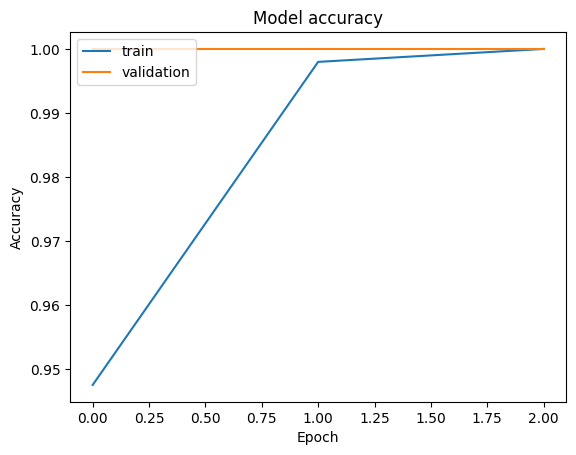

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       867

    accuracy                           1.00      1730
   macro avg       1.00      1.00      1.00      1730
weighted avg       1.00      1.00      1.00      1730

True labels: [0 0 1 1 0 1 1 0 0 0]
Predictions: [0 0 1 1 0 1 1 0 0 0]
Shape of true_labels: (1730,)
Shape of predictions: (1730,)


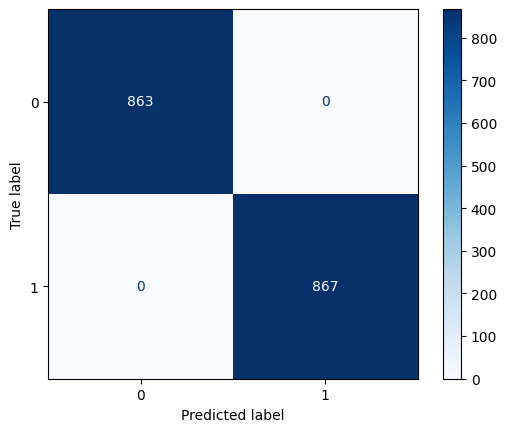

In [11]:
# DIstorsion3

model=create_model()
distorsion3_dir = os.path.join(train_base_dir, 'distorsion3')
process_model(model,distorsion3_dir)

# Sauvegarde du modèle
# model.save('model_dist3.keras') #modele lourd pour push sur git




# Flou Mouvement

Distribution des labels dans le jeu d'entraînement: [3451 3432]
Distribution des labels dans le jeu de validation: [863 858]
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step - accuracy: 0.6053 - loss: 0.8745 - val_accuracy: 0.8972 - val_loss: 0.2344
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.9405 - loss: 0.1546 - val_accuracy: 0.9402 - val_loss: 0.1504
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9606 - loss: 0.0976 - val_accuracy: 0.9733 - val_loss: 0.0806
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.9778 - loss: 0.0654 - val_accuracy: 0.9436 - val_loss: 0.1499
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.9727 - loss: 0.0687 - val_accuracy: 0.9768 - val_loss: 0.0627
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - accuracy: 0.9841 - loss: 0.0482 - val_accuracy: 0.9808 - val_loss: 0.0429
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9967 - loss: 0.0116 

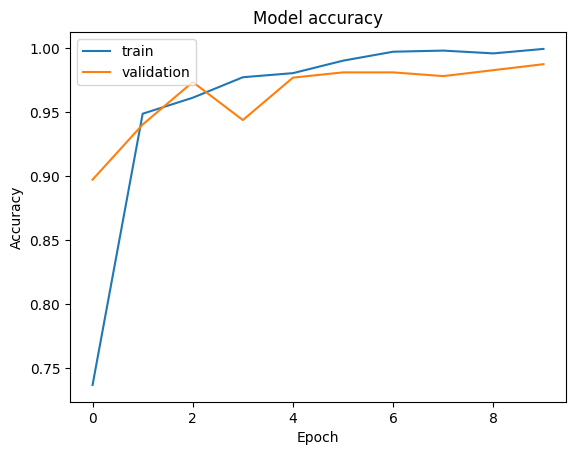

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       863
           1       0.98      1.00      0.99       858

    accuracy                           0.99      1721
   macro avg       0.99      0.99      0.99      1721
weighted avg       0.99      0.99      0.99      1721

True labels: [1 1 0 0 1 1 1 1 1 1]
Predictions: [1 1 0 0 1 1 1 1 1 1]
Shape of true_labels: (1721,)
Shape of predictions: (1721,)


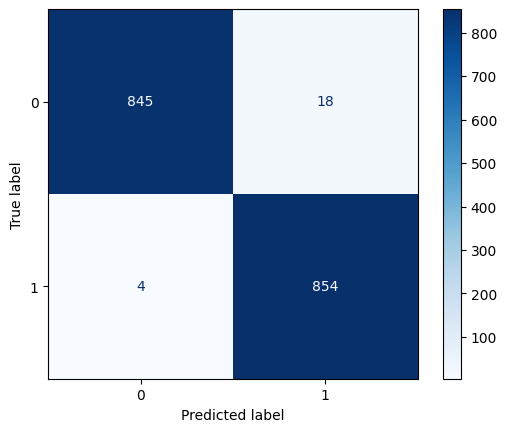

In [14]:
# Mvt1

model=create_model()
mvt1_dir = os.path.join(train_base_dir, 'mvt1')
process_model(model,mvt1_dir)

# Sauvegarde du modèle
# model.save('model_mvt1.keras') #modele lourd pour push sur git


Distribution des labels dans le jeu d'entraînement: [3451 3461]
Distribution des labels dans le jeu de validation: [863 866]
Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 242ms/step - accuracy: 0.6987 - loss: 0.7759 - val_accuracy: 0.9734 - val_loss: 0.0806
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9866 - loss: 0.0438 - val_accuracy: 0.9913 - val_loss: 0.0273
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9960 - loss: 0.0153 - val_accuracy: 0.9907 - val_loss: 0.0290
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.9955 - loss: 0.0131 - val_accuracy: 0.9080 - val_loss: 0.2607
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9697 - loss: 0.0884 - val_accuracy: 0.9867 - val_loss: 0.0410


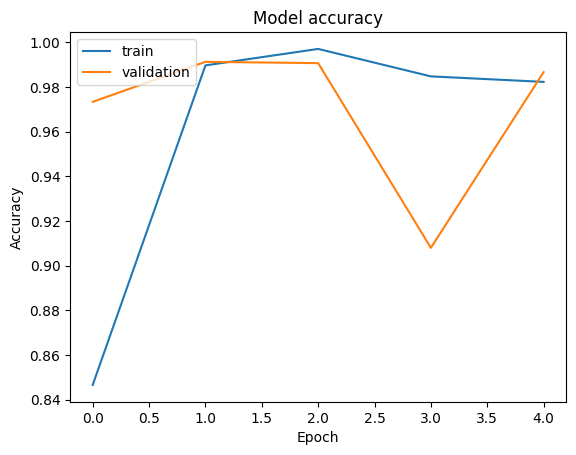

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       863
           1       0.99      0.98      0.99       866

    accuracy                           0.99      1729
   macro avg       0.99      0.99      0.99      1729
weighted avg       0.99      0.99      0.99      1729

True labels: [1 0 0 0 0 1 0 0 0 0]
Predictions: [1 0 0 0 0 1 0 0 0 0]
Shape of true_labels: (1729,)
Shape of predictions: (1729,)


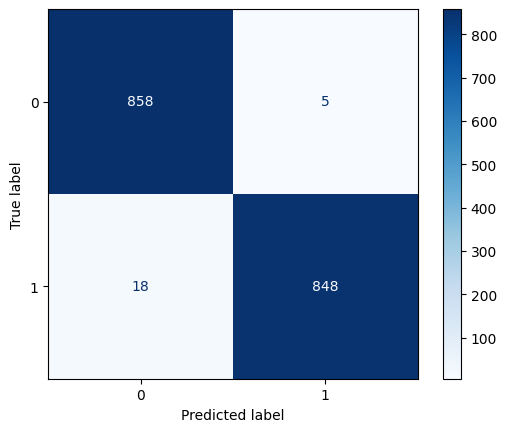

In [16]:
# Mvt2

model=create_model()
mvt2_dir = os.path.join(train_base_dir, 'mvt2')
process_model(model,mvt2_dir)
# Sauvegarde du modèle
# model.save('model_mvt2.keras') #modele lourd pour push sur git


Distribution des labels dans le jeu d'entraînement: [3451 3449]
Distribution des labels dans le jeu de validation: [863 863]
Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 241ms/step - accuracy: 0.7840 - loss: 0.4870 - val_accuracy: 0.9959 - val_loss: 0.0181
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9963 - loss: 0.0133 - val_accuracy: 0.9954 - val_loss: 0.0105
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.9954 - val_loss: 0.0136
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.9854 - loss: 0.0369 - val_accuracy: 0.9965 - val_loss: 0.0106
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - accuracy: 0.9974 - loss: 0.0095 - val_accuracy: 0.9971 - val_loss: 0.0067


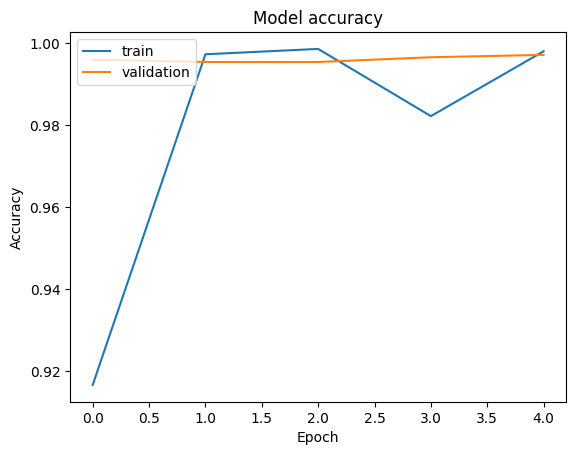

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       863

    accuracy                           1.00      1726
   macro avg       1.00      1.00      1.00      1726
weighted avg       1.00      1.00      1.00      1726

True labels: [1 0 0 0 1 0 0 1 1 1]
Predictions: [1 0 0 0 1 0 0 1 1 1]
Shape of true_labels: (1726,)
Shape of predictions: (1726,)


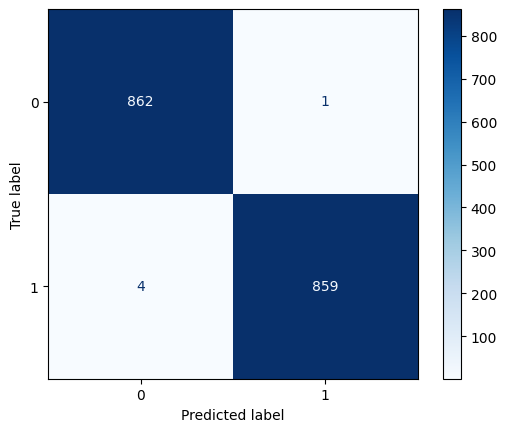

In [17]:
# Mvt3

model=create_model()
mvt3_dir = os.path.join(train_base_dir, 'mvt3')
process_model(model,mvt3_dir)
# Sauvegarde du modèle
# model.save('model_mvt3.keras') #modele lourd pour push sur git



# Flou gaussien

Distribution des labels dans le jeu d'entraînement: [3451 3449]
Distribution des labels dans le jeu de validation: [863 863]
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 242ms/step - accuracy: 0.5351 - loss: 1.1025 - val_accuracy: 0.6767 - val_loss: 0.5941
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.7601 - loss: 0.5051 - val_accuracy: 0.8407 - val_loss: 0.3669
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.8596 - loss: 0.3233 - val_accuracy: 0.9009 - val_loss: 0.3320
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - accuracy: 0.8995 - loss: 0.2519 - val_accuracy: 0.9583 - val_loss: 0.1250
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.9439 - loss: 0.1443 - val_accuracy: 0.9380 - val_loss: 0.1407
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.9559 - loss: 0.1164 - val_accuracy: 0.9612 - val_loss: 0.1026
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.9811 - loss: 0.0570 

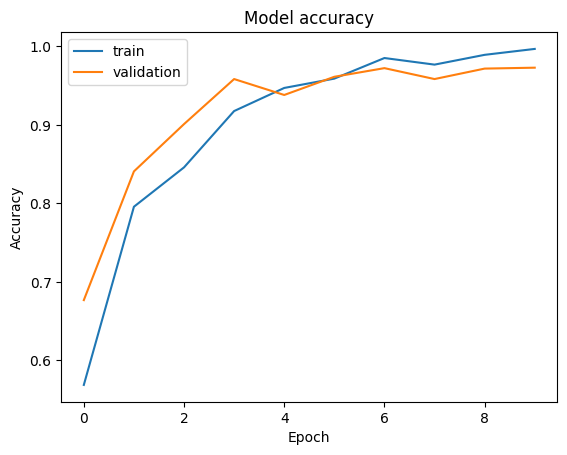

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       863
           1       0.96      0.99      0.97       863

    accuracy                           0.97      1726
   macro avg       0.97      0.97      0.97      1726
weighted avg       0.97      0.97      0.97      1726

True labels: [1 1 0 0 1 1 0 1 0 0]
Predictions: [1 1 0 0 1 1 0 1 0 0]
Shape of true_labels: (1726,)
Shape of predictions: (1726,)


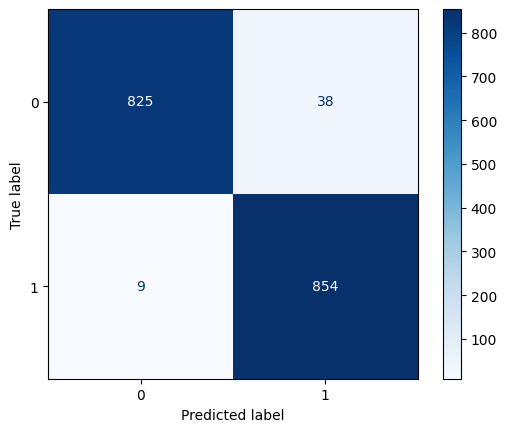

In [19]:
# Gauss1

model=create_model()
gauss1_dir = os.path.join(train_base_dir, 'gauss1')
process_model(model,gauss1_dir)
# Sauvegarde du modèle
# model.save('model_gauss1.keras') #modele lourd pour push sur git



Distribution des labels dans le jeu d'entraînement: [3451 3433]
Distribution des labels dans le jeu de validation: [863 859]
Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 28s 244ms/step - accuracy: 0.7503 - loss: 0.9995 - val_accuracy: 0.9820 - val_loss: 0.0544
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.9844 - loss: 0.0453 - val_accuracy: 0.9744 - val_loss: 0.0689
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9896 - loss: 0.0267 - val_accuracy: 0.9837 - val_loss: 0.0459
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9959 - loss: 0.0170 - val_accuracy: 0.9959 - val_loss: 0.0131
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - accuracy: 0.9995 - loss: 0.0059 - val_accuracy: 0.9890 - val_loss: 0.0289


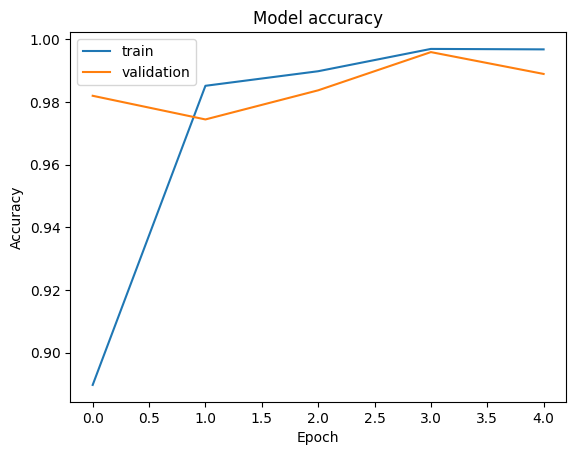

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       863
           1       0.98      0.99      0.99       859

    accuracy                           0.99      1722
   macro avg       0.99      0.99      0.99      1722
weighted avg       0.99      0.99      0.99      1722

True labels: [0 0 0 0 1 1 1 0 0 1]
Predictions: [0 0 0 0 1 1 1 0 0 1]
Shape of true_labels: (1722,)
Shape of predictions: (1722,)


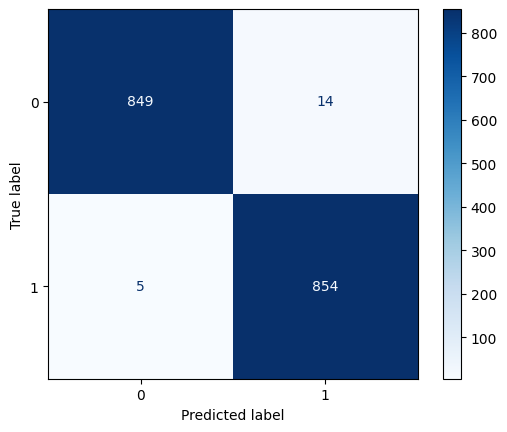

In [22]:
# Gauss2

model=create_model()
gauss2_dir = os.path.join(train_base_dir, 'gauss2')
process_model(model,gauss2_dir)
# Sauvegarde du modèle
# model.save('model_gauss2.keras') #modele lourd pour push sur git


Distribution des labels dans le jeu d'entraînement: [3451 3444]
Distribution des labels dans le jeu de validation: [863 861]
Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - accuracy: 0.7878 - loss: 0.5047 - val_accuracy: 0.9942 - val_loss: 0.0206
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - accuracy: 0.9913 - loss: 0.0229 - val_accuracy: 0.9994 - val_loss: 0.0042
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step - accuracy: 0.9989 - loss: 0.0050 - val_accuracy: 0.9959 - val_loss: 0.0101
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - accuracy: 0.9973 - loss: 0.0080 - val_accuracy: 0.9988 - val_loss: 0.0033
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 248ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 0.9994 - val_loss: 0.0023


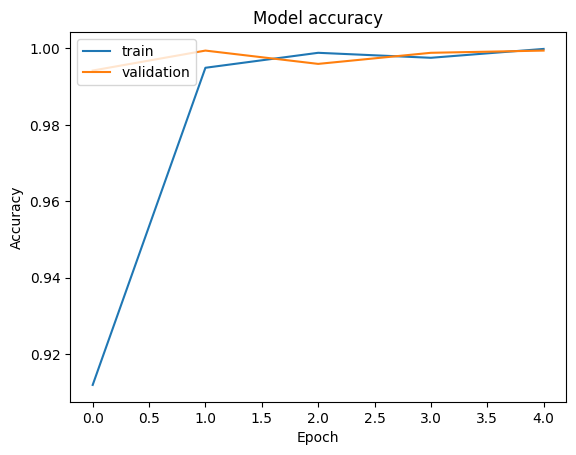

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       861

    accuracy                           1.00      1724
   macro avg       1.00      1.00      1.00      1724
weighted avg       1.00      1.00      1.00      1724

True labels: [1 1 1 0 0 0 1 1 1 0]
Predictions: [1 1 1 0 0 0 1 1 1 0]
Shape of true_labels: (1724,)
Shape of predictions: (1724,)


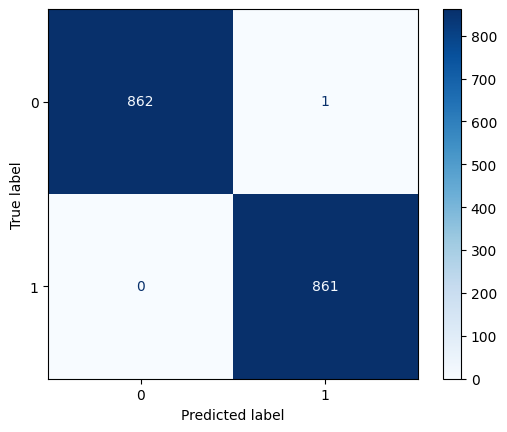

In [23]:
# Gauss3

model=create_model()
gauss3_dir = os.path.join(train_base_dir, 'gauss3')
process_model(model,gauss3_dir)
# Sauvegarde du modèle
# model.save('model_gauss3.keras') #modele lourd pour push sur git


# Pixelisation

Distribution des labels dans le jeu d'entraînement: [3451 3413]
Distribution des labels dans le jeu de validation: [863 853]
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 241ms/step - accuracy: 0.5071 - loss: 0.9464 - val_accuracy: 0.6031 - val_loss: 0.6756
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - accuracy: 0.6267 - loss: 0.6316 - val_accuracy: 0.7022 - val_loss: 0.5455
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.7310 - loss: 0.5080 - val_accuracy: 0.8252 - val_loss: 0.3793
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - accuracy: 0.8600 - loss: 0.3311 - val_accuracy: 0.8846 - val_loss: 0.3013
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.8821 - loss: 0.2925 - val_accuracy: 0.8531 - val_loss: 0.3579
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.8987 - loss: 0.2459 - val_accuracy: 0.8724 - val_loss: 0.2916
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - accuracy: 0.9620 - loss: 0.1049 

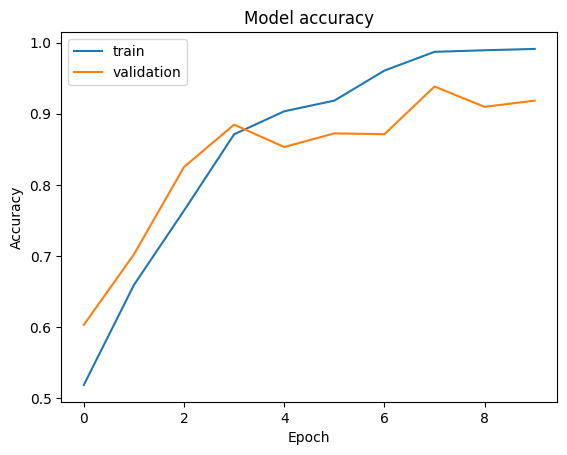

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       863
           1       0.99      0.85      0.91       853

    accuracy                           0.92      1716
   macro avg       0.93      0.92      0.92      1716
weighted avg       0.93      0.92      0.92      1716

True labels: [0 0 0 0 1 1 0 0 0 1]
Predictions: [0 0 0 0 1 1 0 0 0 1]
Shape of true_labels: (1716,)
Shape of predictions: (1716,)


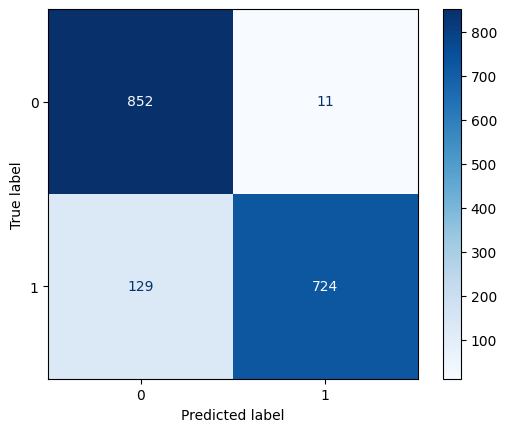

In [25]:
# Pixel1

model=create_model()
pixel1_dir = os.path.join(train_base_dir, 'pixel1')
process_model(model,pixel1_dir)
# Sauvegarde du modèle
# model.save('model_pixel1.keras') #modele lourd pour push sur git


Distribution des labels dans le jeu d'entraînement: [3451 3413]
Distribution des labels dans le jeu de validation: [863 853]
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 237ms/step - accuracy: 0.5045 - loss: 0.9011 - val_accuracy: 0.5472 - val_loss: 0.6925
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.5552 - loss: 0.6842 - val_accuracy: 0.6206 - val_loss: 0.6522
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - accuracy: 0.6449 - loss: 0.6281 - val_accuracy: 0.6585 - val_loss: 0.6018
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - accuracy: 0.6978 - loss: 0.5565 - val_accuracy: 0.7273 - val_loss: 0.5179
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 28s 258ms/step - accuracy: 0.7602 - loss: 0.4878 - val_accuracy: 0.7535 - val_loss: 0.5028
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.8280 - loss: 0.3961 - val_accuracy: 0.8607 - val_loss: 0.3081
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - accuracy: 0.8708 - loss: 0.3063 

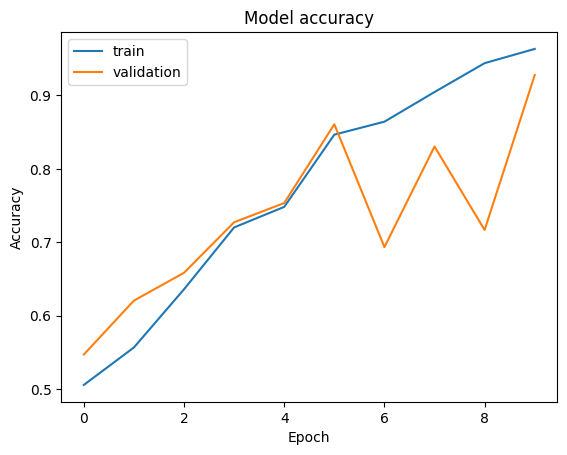

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       863
           1       0.90      0.96      0.93       853

    accuracy                           0.93      1716
   macro avg       0.93      0.93      0.93      1716
weighted avg       0.93      0.93      0.93      1716

True labels: [0 0 0 1 0 1 1 0 0 0]
Predictions: [0 0 0 1 0 1 1 0 0 0]
Shape of true_labels: (1716,)
Shape of predictions: (1716,)


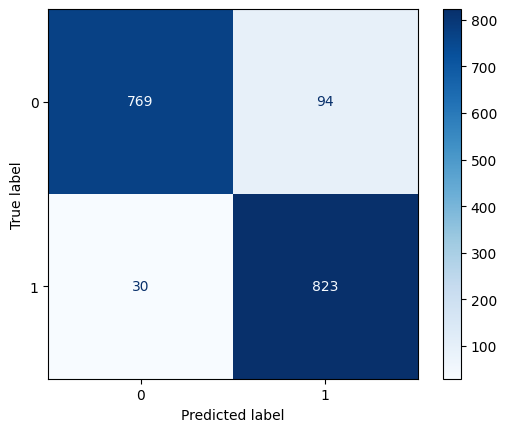

In [30]:
# Pixel2

model=create_model()
pixel2_dir = os.path.join(train_base_dir, 'pixel1')
process_model(model,pixel2_dir)
# Sauvegarde du modèle
# model.save('model_pixel2.keras') #modele lourd pour push sur git

Distribution des labels dans le jeu d'entraînement: [3451 3436]
Distribution des labels dans le jeu de validation: [863 859]
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 229ms/step - accuracy: 0.5753 - loss: 0.8135 - val_accuracy: 0.9036 - val_loss: 0.4205
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - accuracy: 0.9213 - loss: 0.3942 - val_accuracy: 0.9553 - val_loss: 0.3292
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 213ms/step - accuracy: 0.9366 - loss: 0.2732 - val_accuracy: 0.9460 - val_loss: 0.1422
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - accuracy: 0.9637 - loss: 0.0995 - val_accuracy: 0.9216 - val_loss: 0.2474
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - accuracy: 0.9825 - loss: 0.0586 - val_accuracy: 0.9721 - val_loss: 0.0772
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - accuracy: 0.9955 - loss: 0.0169 - val_accuracy: 0.9733 - val_loss: 0.0632
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - accuracy: 0.9986 - loss: 0.0083 

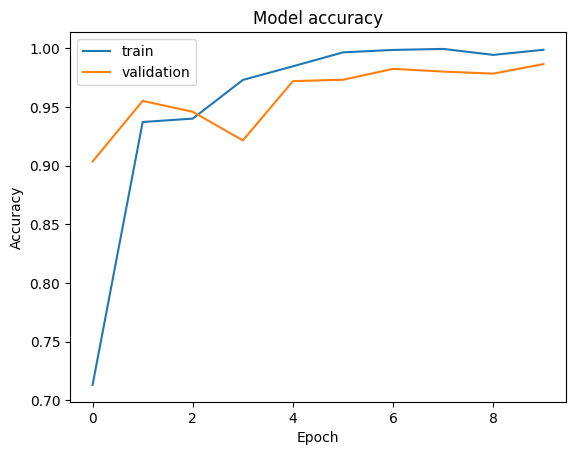

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       863
           1       0.98      0.99      0.99       859

    accuracy                           0.99      1722
   macro avg       0.99      0.99      0.99      1722
weighted avg       0.99      0.99      0.99      1722

True labels: [0 0 1 0 1 0 0 1 1 1]
Predictions: [0 0 1 0 1 0 0 1 1 1]
Shape of true_labels: (1722,)
Shape of predictions: (1722,)


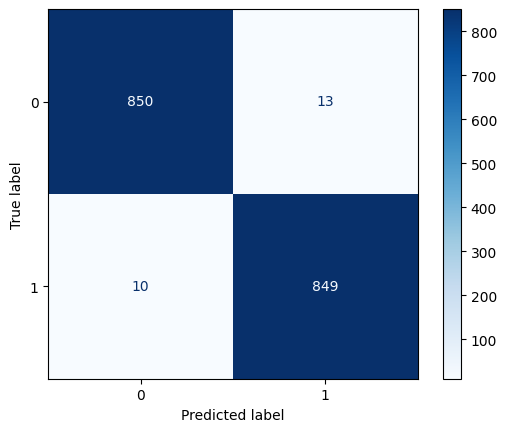

In [31]:
# Pixel3

model=create_model()
pixel3_dir = os.path.join(train_base_dir, 'pixel3')
process_model(model,pixel3_dir)
# Sauvegarde du modèle
# model.save('model_pixel3.keras') #modele lourd pour push sur git

# Pixel Permutation

In [32]:
# PixelPermut1

model=create_model()
pixelpermut1_dir = os.path.join(train_base_dir, 'pixelpermut1')
process_model(model,pixelpermut1_dir)
# Sauvegarde du modèle
# model.save('model_pixelpermut1.keras') #modele lourd pour push sur git

Distribution des labels dans le jeu d'entraînement: [3451 3421]
Distribution des labels dans le jeu de validation: [863 855]
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 208ms/step - accuracy: 0.9308 - loss: 0.1432 - val_accuracy: 0.9994 - val_loss: 8.6391e-04
Epoch 2/10
 33/108 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 1.0000 - loss: 7.6551e-06

KeyboardInterrupt: 

In [ ]:
# PixelPermut2

model=create_model()
pixelpermut2_dir = os.path.join(train_base_dir, 'pixelpermut2')
process_model(model,pixelpermut2_dir)
# Sauvegarde du modèle
# model.save('model_pixelpermut2.keras') #modele lourd pour push sur git

In [ ]:
# PixelPermut3

model=create_model()
pixelpermut3_dir = os.path.join(train_base_dir, 'pixelpermut3')
process_model(model,pixelpermut3_dir)
# Sauvegarde du modèle
# model.save('model_pixelpermut3.keras') #modele lourd pour push sur git

#  FGSM

In [ ]:
# FGSM 1
model=create_model()
fgsm1_dir = os.path.join(train_base_dir, 'fgsm1')
process_model(model,fgsm1_dir)
# Sauvegarde du modèle
# model.save('model_pixelpermut3.keras') #modele lourd pour push sur git

Distribution des labels dans le jeu d'entraînement: [3451 5258]
Distribution des labels dans le jeu de validation: [ 863 1315]
Epoch 1/3


2024-11-18 10:28:37.974366: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 10:28:38.079563: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5989 - loss: 0.8543

In [ ]:
# FGSM 2
model=create_model()
fgsm2_dir = os.path.join(train_base_dir, 'fgsm2')
process_model(model,fgsm2_dir)
# Sauvegarde du modèle
# model.save('model_pixelpermut3.keras') #modele lourd pour push sur git

In [ ]:
# FGSM 3
model=create_model()
fgsm3_dir = os.path.join(train_base_dir, 'fgsm3')
process_model(model,fgsm3_dir)
# Sauvegarde du modèle
# model.save('model_pixelpermut3.keras') #modele lourd pour push sur git